In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt

In [3]:
os.listdir("/tmp/pvc/data/")

['kepler_node_dram_joules_total_data_20240905-142038.csv',
 'kepler_node_other_joules_total_data_20240905-142138.csv',
 'kepler_node_package_joules_total_data_20240905-142239.csv',
 'kepler_node_platform_joules_total_data_20240905-142339.csv',
 'node_cpu_seconds_total_data_20240905-142445.csv',
 'kepler_node_dram_joules_total_data_20240905-143527.csv',
 'kepler_node_dram_joules_total_data_20240905-154638.csv',
 'kepler_node_other_joules_total_data_20240905-154739.csv',
 'kepler_node_package_joules_total_data_20240905-154839.csv',
 'kepler_node_platform_joules_total_data_20240905-154939.csv',
 'node_cpu_seconds_total_data_20240905-155043.csv']

In [6]:
data_folder = "data/data_old/"
cpu_util_file = "node_cpu_seconds_total_2024-03-06 15:40:17.542294.csv"
node_package_power_file = "kepler_node_package_joules_total_2024-03-06 15:42:38.272860.csv"
node_dram_power_file = "kepler_node_dram_joules_total_2024-03-06 15:42:35.234877.csv"

In [7]:
cpu_util = pd.read_csv(data_folder+cpu_util_file)
cpu_util = cpu_util[cpu_util['mode']!='idle']
cpu_util_agg = cpu_util.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
cpu_util_agg['timestamp'] = pd.to_datetime(cpu_util_agg['timestamp'])

node_package_power = pd.read_csv(data_folder+node_package_power_file)
node_package_power = node_package_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_package_power['timestamp'] = pd.to_datetime(node_package_power['timestamp'])

node_dram_power = pd.read_csv(data_folder+node_dram_power_file)
node_dram_power = node_dram_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_dram_power['timestamp'] = pd.to_datetime(node_dram_power['timestamp'])

In [8]:
node_power_metrics = pd.merge(node_package_power, node_dram_power, on = ["timestamp", "instance"])
node_power_metrics = node_power_metrics.rename(columns={"value_x":"package", "value_y":"dram"})
node_power_metrics['power'] = node_power_metrics['package'] + node_power_metrics['dram']

In [ ]:
print("New code Parul")

In [22]:
directory="/tmp/pvc/data/"
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]
dataframes = []
metrics_file_map = {}

# Load each CSV file and append to the list
for csv_file in csv_files:
    file_path=""
    if "node_cpu_seconds" in csv_file:
        file_path = os.path.join(directory, csv_file)
        metrics_file_map.update({"cpu_util":file_path})
    elif "kepler_node_package_joules_total" in csv_file:
        file_path = os.path.join(directory, csv_file)
        metrics_file_map.update({"node_package_power":file_path})
    elif "kepler_node_dram_joules_total" in csv_file:
        file_path = os.path.join(directory, csv_file)
        metrics_file_map.update({"node_dram_power":file_path})

print(f"Metric files{metrics_file_map}")

Metric files{'node_dram_power': '/tmp/pvc/data/kepler_node_dram_joules_total_data_20240905-163327.csv', 'node_package_power': '/tmp/pvc/data/kepler_node_package_joules_total_data_20240905-163527.csv', 'cpu_util': '/tmp/pvc/data/node_cpu_seconds_total_data_20240905-163734.csv'}


In [23]:
cpu_util = pd.read_csv(metrics_file_map.get("cpu_util"))
cpu_util = cpu_util[cpu_util['mode']!='idle']
cpu_util_agg = cpu_util.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
cpu_util_agg['timestamp'] = pd.to_datetime(cpu_util_agg['timestamp'])


node_package_power = pd.read_csv(metrics_file_map.get("node_package_power"))
node_package_power = node_package_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_package_power['timestamp'] = pd.to_datetime(node_package_power['timestamp'])

node_dram_power = pd.read_csv(metrics_file_map.get("node_dram_power"))
node_dram_power = node_dram_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_dram_power['timestamp'] = pd.to_datetime(node_dram_power['timestamp'])

node_power_metrics = pd.merge(node_package_power, node_dram_power, on = ["timestamp", "instance"])
node_power_metrics = node_power_metrics.rename(columns={"value_x":"package", "value_y":"dram"})
node_power_metrics['power'] = node_power_metrics['package'] + node_power_metrics['dram']

In [24]:
node_power_metrics

,instance,timestamp,package,dram,power
0,kind-control-plane,1970-01-01 00:00:01.725533400,3.726109e+08,2.803890e+08,6.529999e+08
1,kind-control-plane,1970-01-01 00:00:01.725533460,3.726216e+08,2.803962e+08,6.530179e+08
2,kind-control-plane,1970-01-01 00:00:01.725533520,3.726317e+08,2.804033e+08,6.530350e+08
3,kind-control-plane,1970-01-01 00:00:01.725533580,3.726413e+08,2.804099e+08,6.530513e+08
4,kind-control-plane,1970-01-01 00:00:01.725533640,3.726512e+08,2.804168e+08,6.530681e+08
...,...,...,...,...,...
99,kind-worker2,1970-01-01 00:00:01.725536940,3.845326e+08,2.909100e+08,6.754426e+08
100,kind-worker2,1970-01-01 00:00:01.725537000,3.845428e+08,2.909169e+08,6.754597e+08
101,kind-worker2,1970-01-01 00:00:01.725537060,3.845519e+08,2.909233e+08,6.754752e+08
102,kind-worker2,1970-01-01 00:00:01.725537120,3.845623e+08,2.909304e+08,6.754927e+08


In [26]:
import model

Node :  kind-control-plane


/tmp/ipykernel_1744192/1535336038.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


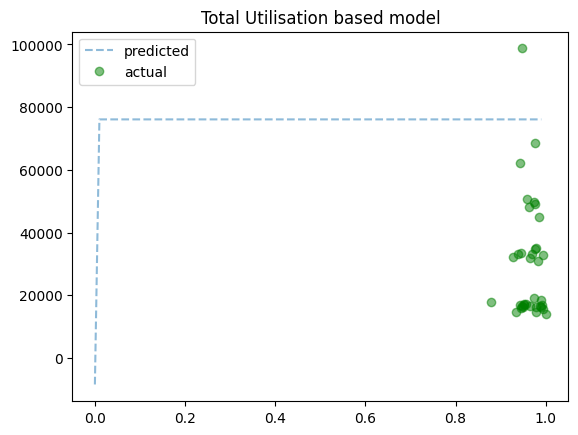

Node :  kind-worker


/tmp/ipykernel_1744192/1535336038.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


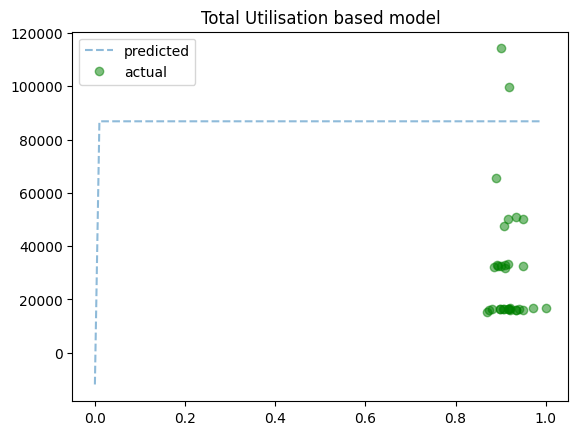

Node :  kind-worker2


/tmp/ipykernel_1744192/1535336038.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


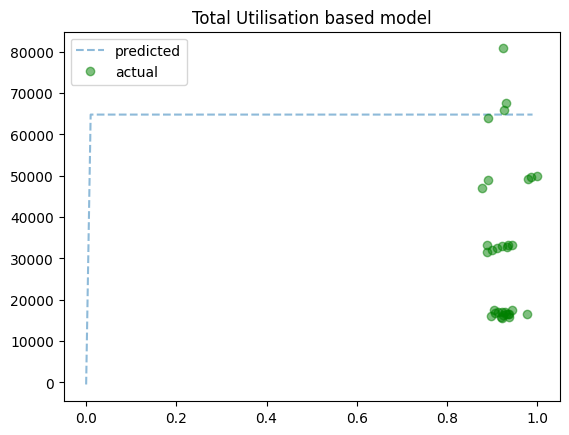

In [28]:
node_power_models = {}
for node in cpu_util_agg['instance'].unique():
    print("Node : ", node)
    cpu = cpu_util_agg[cpu_util_agg['instance']==node]
    power = node_power_metrics[node_power_metrics['instance']==node]
    data = pd.merge_asof(cpu, power, on = 'timestamp')
    data.rename(columns={'value':'util'}, inplace=True)
    data.sort_values('timestamp', inplace=True)
    m = model.UtilisationPowerModel()
    
    node_df = data
    node_df['util'] = node_df['util'].diff()
    node_df['energy'] = node_df['power'].diff()
    node_df.fillna(0, inplace=True)

#     node_df = node_df.iloc[500: , :]

    node_df = node_df[(node_df[['util']] != 0).all(axis=1)]
    node_df = node_df[(node_df[['energy']] != 0).all(axis=1)]
    max_util = max(node_df['util'])
    node_df['util'] = node_df['util']/max_util

    node_df['power'] = node_df['energy']
    node_df['power'].fillna(node_df['power'].mean(), inplace=True)
    node_power_models[node] = m.get_model(node_df[['util', 'power']])

SyntaxError: invalid syntax (1747701846.py, line 1)

In [10]:
pip3 install torch
import model

SyntaxError: invalid syntax (629369937.py, line 1)

Node :  tantawi1


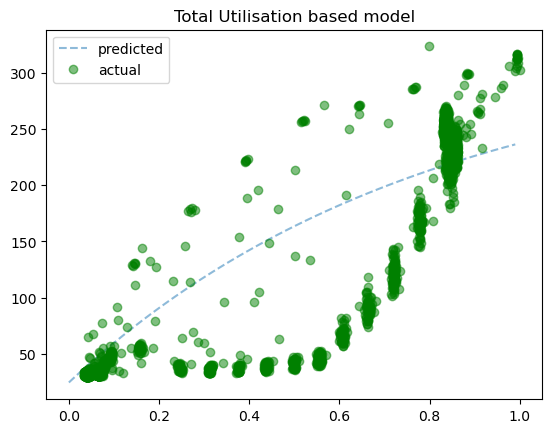

Node :  tantawi2


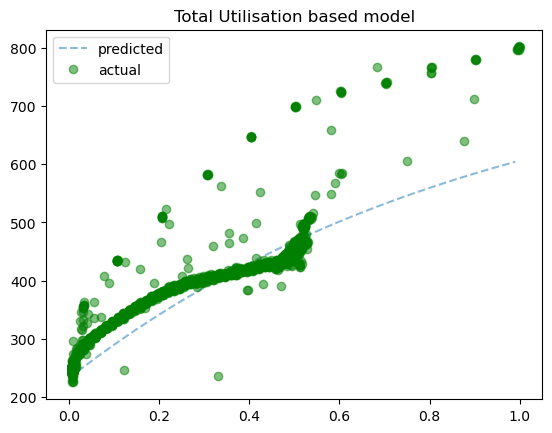

In [11]:
node_power_models = {}
for node in cpu_util_agg['instance'].unique():
    print("Node : ", node)
    cpu = cpu_util_agg[cpu_util_agg['instance']==node]
    power = node_power_metrics[node_power_metrics['instance']==node]
    data = pd.merge_asof(cpu, power, on = 'timestamp')
    data.rename(columns={'value':'util'}, inplace=True)
    data.sort_values('timestamp', inplace=True)
    m = model.UtilisationPowerModel()
    
    node_df = data
    node_df['util'] = node_df['util'].diff()
    node_df['energy'] = node_df['power'].diff()
    node_df.fillna(0, inplace=True)

#     node_df = node_df.iloc[500: , :]

    node_df = node_df[(node_df[['util']] != 0).all(axis=1)]
    node_df = node_df[(node_df[['energy']] != 0).all(axis=1)]
    max_util = max(node_df['util'])
    node_df['util'] = node_df['util']/max_util

    node_df['power'] = node_df['energy']/3
    node_df['power'].fillna(node_df['power'].mean(), inplace=True)
    node_power_models[node] = m.get_model(node_df[['util', 'power']])

In [12]:
for node in node_power_models:
    print(node,node_power_models[node][2])

tantawi1 (tensor(321.3858, requires_grad=True), tensor(-297.0492, requires_grad=True), tensor(-1.2640, requires_grad=True))
tantawi2 (tensor(806.0183, requires_grad=True), tensor(-573.6005, requires_grad=True), tensor(-1.0555, requires_grad=True))


In [10]:
def get_power(k0, k1, k2, util):
    return k0+k1*np.exp(k2*util)

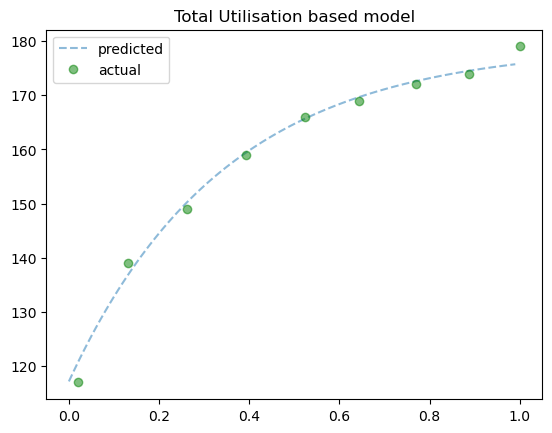

(array([[120.7159 ],
        [136.79349],
        [150.19792],
        [159.3664 ],
        [165.63751],
        [169.65163],
        [172.57628],
        [174.5247 ],
        [175.82265]], dtype=float32),
 [2038.41748046875,
  5.147364616394043,
  3.6360321044921875,
  3.5537467002868652,
  3.541675090789795,
  3.534393310546875,
  3.5275373458862305,
  3.520735502243042,
  3.5139575004577637,
  3.5072314739227295],
 (tensor(179.2110, requires_grad=True),
  tensor(-62.0149, requires_grad=True),
  tensor(-2.9070, requires_grad=True)))

In [21]:
# T1
util = [2,13,26,39,52,64,76.5,88.4,99.5]
power = [117,139,149,159,166,169,172,174,179]
data = pd.DataFrame({'util':util, 'power':power})
data['util'] = data['util']/max(data['util'])
m = model.UtilisationPowerModel()
m.get_model(data)

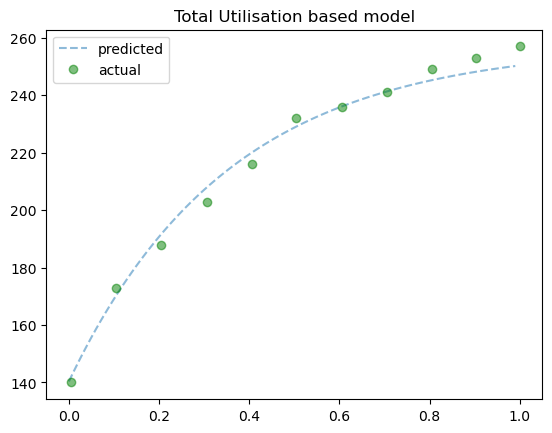

(array([[141.68747],
        [170.15373],
        [191.61765],
        [207.94159],
        [220.0047 ],
        [229.12616],
        [236.08359],
        [241.32959],
        [245.28513],
        [248.2159 ],
        [250.39876]], dtype=float32),
 [7156.525390625,
  14.2857084274292,
  14.243882179260254,
  14.20327091217041,
  14.16290283203125,
  14.122781753540039,
  14.082930564880371,
  14.04330825805664,
  14.003939628601074,
  13.964327812194824],
 (tensor(257.4099, requires_grad=True),
  tensor(-117.0368, requires_grad=True),
  tensor(-2.8150, requires_grad=True)))

In [22]:
# T2
util = [0.4,10.4,20.4,30.5,40.4,50.3,60.3,70.3,80.3,90.1,99.7]
power = [140,173,188,203,216,232,236,241,249,253,257]
data = pd.DataFrame({'util':util, 'power':power})
data['util'] = data['util']/max(data['util'])
m = model.UtilisationPowerModel()
m.get_model(data)

In [19]:
import torch
from torch.autograd import Variable

In [16]:
def get_power(u, model):
    return model[0] + model[1] * torch.exp(model[2] * u)

In [17]:
model1 = node_power_models['tantawi1'][2]
model2 = node_power_models['tantawi2'][2]

In [32]:
x = [i/100 for i in range(400)]
y1 = [get_power(i, model1).data for i in x]
y2 = [get_power(i, model2).data for i in x]

Text(0, 0.5, 'Instantaneous Power')

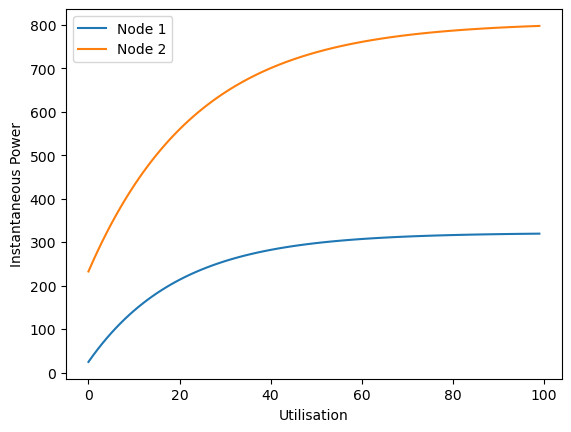

In [35]:
plt.plot(y1[::4])
plt.plot(y2[::4])
plt.legend(['Node 1', 'Node 2'])
plt.xlabel("Utilisation")
plt.ylabel("Instantaneous Power")